In [ ]:
!pip install -q torchmetrics

#  **Import Libs**

In [ ]:
'''!pip install -q pandas==1.5.3
!pip install -q numpy==1.23.5
!pip install -q torchvision==0.15.2
!pip install -q torchmetrics
!pip install -q tqdm==4.66.1
!pip install -q torch==2.0.1'''

'!pip install -q pandas==1.5.3\n!pip install -q numpy==1.23.5\n!pip install -q torchvision==0.15.2\n!pip install -q torchmetrics\n!pip install -q tqdm==4.66.1\n!pip install -q torch==2.0.1'

In [ ]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2 as cv
import PIL
from PIL import Image

import sklearn
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch import optim
from torch.nn import functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import tqdm
import torchmetrics as tm

#  **Utils**

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

#  **Dataset**

##  **Copy & Unzip the Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unrar e '/content/drive/MyDrive/Deep Learning Projects/0-Facial Age Estimation/Data/UTKFace.rar' '/content/Data/'

* x: This flag stands for "extract". It tells the tar command to extract the files from the archive.

* v: This flag stands for "verbose". It displays the list of files being extracted in the terminal.

* z: This flag indicates that the archive file is compressed using gzip.

* f: This flag indicates that the following argument is the name of the archive file.

##  EDA

###  Let's explore the images in the UTK dataset together!

 Download the UFTK dataset to your computer:


*   explore it
*   then list five observations or interesting characteristics you find in the dataset.



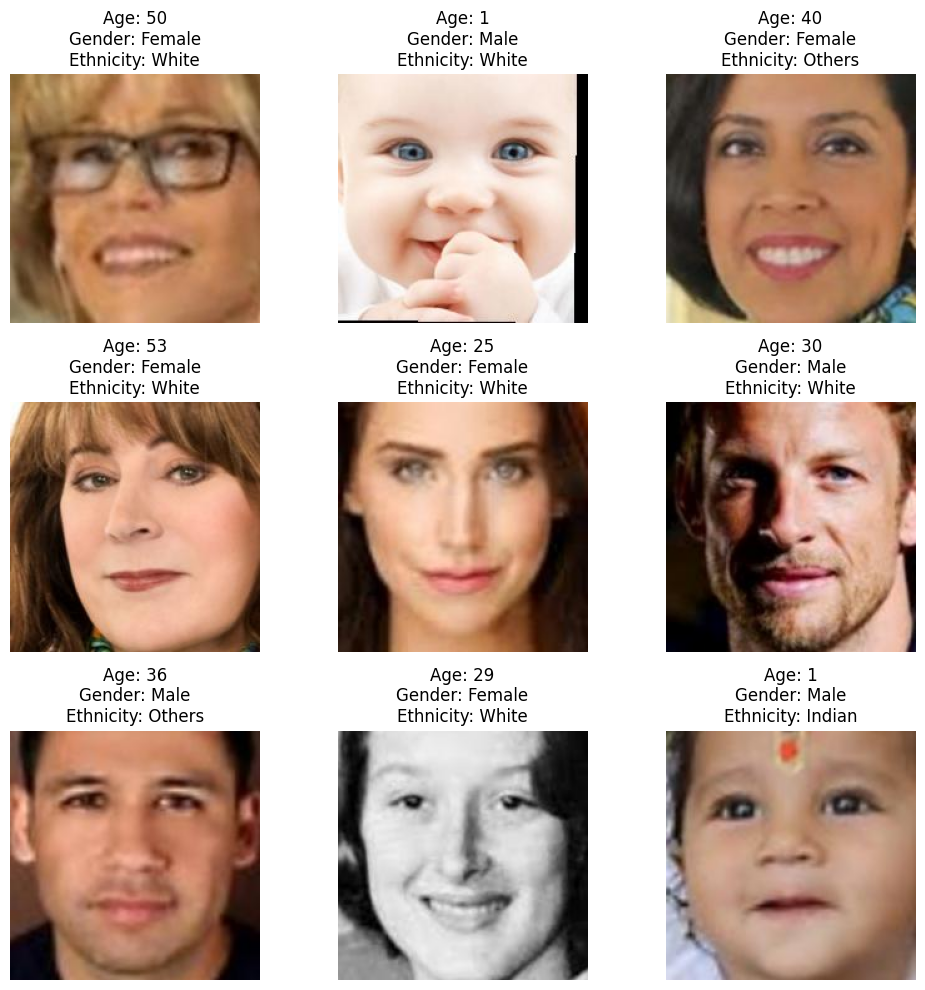

In [ ]:
# Replace with the actual path to your UTK dataset images folder
dataset_folder = '/content/Data/'

def show_random_samples(num_samples=9):
    image_files = os.listdir(dataset_folder)
    selected_image_files = random.sample(image_files, num_samples)

    plt.figure(figsize=(10, 10))
    for idx, image_file in enumerate(selected_image_files, 1):
        image_path = os.path.join(dataset_folder, image_file)
        age, gender, ethnicity = image_file.split('_')[:3]

        image = Image.open(image_path)

        gender = 'Male' if int(gender) == 0 else 'Female'
        ethnicity = ['White', 'Black', 'Asian', 'Indian', 'Others'][int(ethnicity)]

        plt.subplot(3, 3, idx)
        plt.imshow(image)
        plt.title(f"Age: {age}\nGender: {gender}\nEthnicity: {ethnicity}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to display random samples
show_random_samples()


###  Create a csv file which contains labels

🔰 During this session, your mission is to:
   

*   create the following DataFrame
*   and save it as a CSV file named 'utkface_dataset.csv'


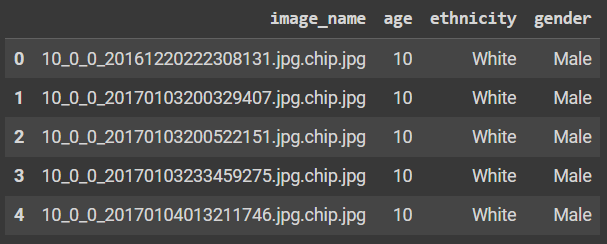

In [ ]:
# Dataset path
folder_address = "/content/Data/"

image_names = os.listdir(folder_address)
lst = []
for i , img_name in enumerate(image_names):
    fields = img_name.split('_')

    if len(fields) < 4:
        print(img_name)
        continue

    if int(fields[0])>80:
        continue

    lst.append([img_name,int(fields[0]),['White', 'Black', 'Asian', 'Indian', 'Others'][int(fields[2])]
                ,'Male' if int(fields[1])==0 else 'Female'])

df = pd.DataFrame(lst, columns=['image_name','age','ethnicity','gender'])
df.to_csv('/content/Data/UTKFace_dataset.csv')

df.head(10)


61_1_20170109150557335.jpg.chip.jpg
61_1_20170109142408075.jpg.chip.jpg
39_1_20170116174525125.jpg.chip.jpg


,image_name,age,ethnicity,gender
0,26_1_4_20170117200419213.jpg.chip.jpg,26,Others,Female
1,23_1_2_20170116172910708.jpg.chip.jpg,23,Asian,Female
2,26_0_3_20170119144035406.jpg.chip.jpg,26,Indian,Male
3,30_0_1_20170116010614771.jpg.chip.jpg,30,Black,Male
4,7_0_1_20170110224345168.jpg.chip.jpg,7,Black,Male
5,17_0_2_20170105183230223.jpg.chip.jpg,17,Asian,Male
6,28_0_3_20170119194803955.jpg.chip.jpg,28,Indian,Male
7,35_0_1_20170113182403214.jpg.chip.jpg,35,Black,Male
8,25_1_3_20170104234854715.jpg.chip.jpg,25,Indian,Female
9,24_1_3_20170104215731414.jpg.chip.jpg,24,Indian,Female


###  Plot histogram for age

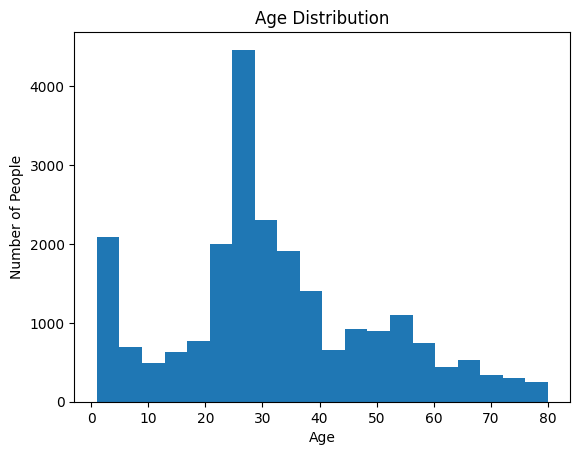

In [ ]:
from re import VERBOSE
fig, ax = plt.subplots()
plt.xlabel('Age')
plt.ylabel('Number of People')
plt.title('Age Distribution')
ax.hist(df['age'],bins=20,);

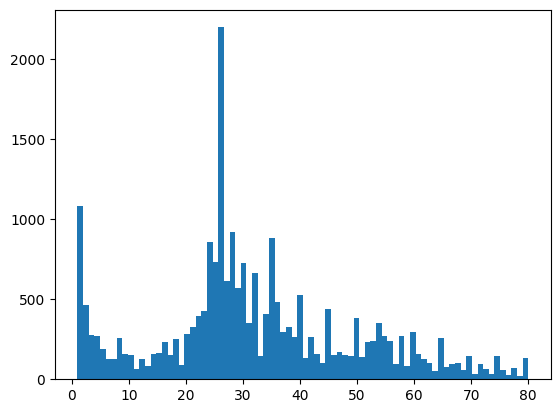

In [ ]:
plt.hist(df.age,len(df.age.unique()));

In [ ]:
df.age.describe()

count    22947.000000
mean        32.231795
std         18.164379
min          1.000000
25%         23.000000
50%         29.000000
75%         43.000000
max         80.000000
Name: age, dtype: float64

###  Plot histogram for gender

age
26    2197
1     1083
28     918
35     880
24     859
      ... 
64      50
71      33
74      32
77      28
79      23
Name: count, Length: 80, dtype: int64

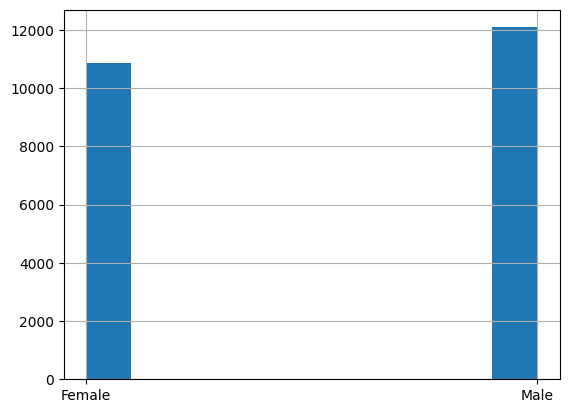

In [ ]:
df.gender.hist(rwidth=5);
df.age.value_counts()

###  Plot histogram for ethnicity

(array([1666., 3314., 3920., 4429., 9618.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. ]),
 <BarContainer object of 5 artists>)

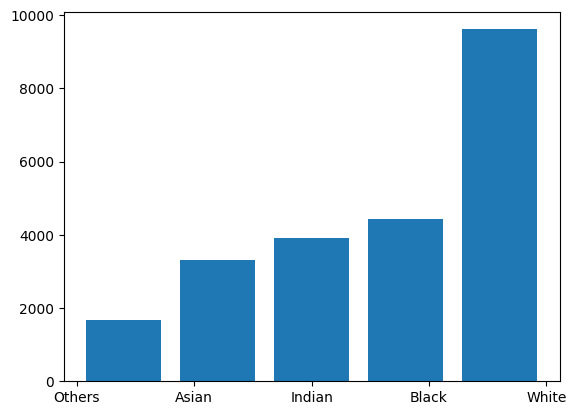

In [ ]:
plt.hist(df.ethnicity, bins=len(df.ethnicity.unique()),rwidth=0.8)

###  Calculate the cross-tabulation of gender and ethnicity using the pandas.crosstab() function.

In [ ]:
pd.crosstab(index=df.gender, columns=df.ethnicity)

ethnicity,Asian,Black,Indian,Others,White
gender,,,,,
Female,1793,2155,1682,922,4306
Male,1521,2274,2238,744,5312


###  Create violin plots and box plots for age, separately for men and women.

{'bodies': [<matplotlib.collections.PolyCollection at 0x7e55306d3700>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7e55306d3670>,
 'cmins': <matplotlib.collections.LineCollection at 0x7e55307040d0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7e5530704460>}

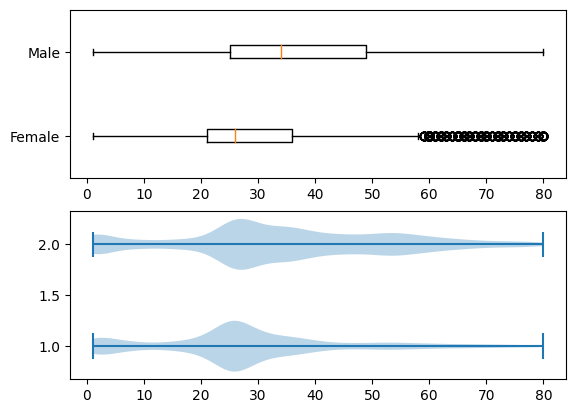

In [ ]:
plt.subplot(2,1,1)
plt.boxplot([df.age[df.gender=='Female'],df.age[df.gender=='Male']],vert=False, labels=['Female','Male']);

plt.subplot(2,1,2)
plt.violinplot([df.age[df.gender=='Female'],df.age[df.gender=='Male']],vert=False)

{'whiskers': [<matplotlib.lines.Line2D at 0x7e553058f010>,
 'caps': [<matplotlib.lines.Line2D at 0x7e553058f550>,
 'boxes': [<matplotlib.lines.Line2D at 0x7e553058ed70>],
 'medians': [<matplotlib.lines.Line2D at 0x7e553058fa90>],
 'fliers': [<matplotlib.lines.Line2D at 0x7e553058fd30>],
 'means': []}

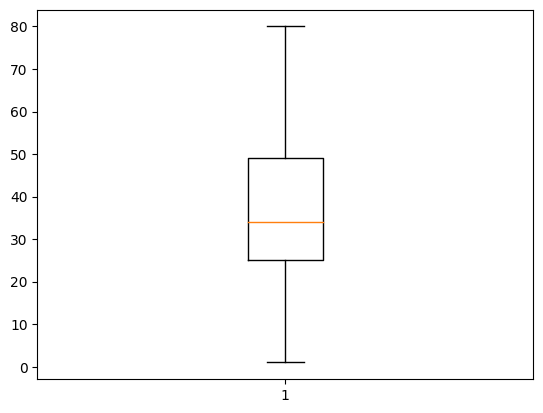

In [ ]:
plt.boxplot(df.age[df.gender=='Male'])

###  Create violin plots and box plots for age, separately for each ethnicity.

{'bodies': [<matplotlib.collections.PolyCollection at 0x7e553049b5e0>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7e553049b5b0>,
 'cmins': <matplotlib.collections.LineCollection at 0x7e55304d09d0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7e55304d0df0>}

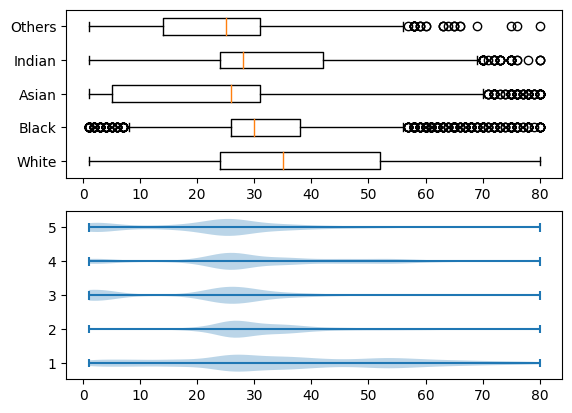

In [ ]:
plt.subplot(2,1,1)
plt.boxplot([df.age[df.ethnicity=='White'],df.age[df.ethnicity=='Black'],df.age[df.ethnicity=='Asian'],
             df.age[df.ethnicity=='Indian'],df.age[df.ethnicity=='Others']],vert=False,
            labels=['White', 'Black', 'Asian', 'Indian', 'Others'])
plt.subplot(2,1,2)
plt.violinplot([df.age[df.ethnicity=='White'],df.age[df.ethnicity=='Black'],df.age[df.ethnicity=='Asian'],
             df.age[df.ethnicity=='Indian'],df.age[df.ethnicity=='Others']],vert=False)

##  Split datasets

🔰 During this session, your task is to use scikit-learn's train_test_split function to partition the dataset into training, validation, and test sets.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
df_train, temp = train_test_split(df, test_size=0.3, stratify=df.age, random_state=18)
df_test, df_valid = train_test_split(temp, test_size=0.5, stratify=temp.age, random_state=18)

###  Plot histograms for age in the training, validation, and test sets.

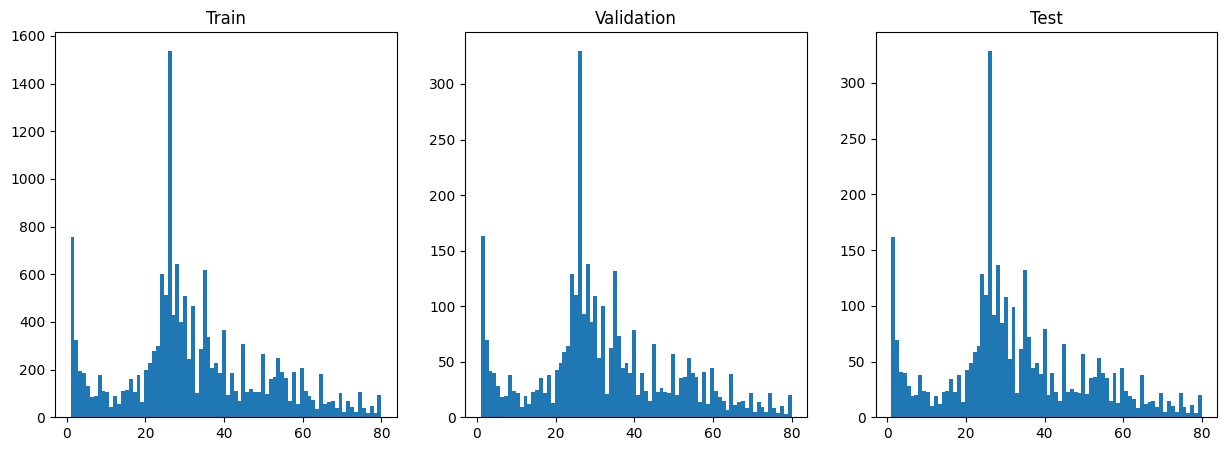

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(df_train.age, bins=len(df_train.age.unique())); axes[0].set_title('Train')
axes[1].hist(df_valid.age, bins=len(df_valid.age.unique())); axes[1].set_title('Validation')
axes[2].hist(df_test.age, bins=len(df_test.age.unique())); axes[2].set_title('Test');

###  Save the training, validation, and test sets in separate CSV files.

In [ ]:
df_train.to_csv('/content/train_set.csv', index=False)
df_valid.to_csv('/content/valid_set.csv', index=False)
df_test.to_csv('/content/test_set.csv', index=False)

print('All CSV files created successfully.')

All CSV files created successfully.


##  Define transformations

🔰 During this session, your mission is to implement a data transformation pipeline using PyTorch's transforms.
The transformations should include:

*   Resizing images to a resolution of 128x128 pixels.
*   Applying random horizontal flips to the images.
*   Introducing random rotations of 15 degrees.
*   Adjusting image color using the ColorJitter transformation.
*   Converting the images to tensors.
*   Normalizing the pixel values using the provided mean and standard deviation values `(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`.

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

##  Custom dataset

🔰 Write a custom dataset class for UTKFace.

In [ ]:
class UTKDataset(Dataset):

    def __init__(self, root_dir, csv_file, transform=None):

      '''Initialization of UTKDataset '''

      self.data = pd.read_csv(csv_file)
      self.root_dir = root_dir
      self.transform = transform
      self.g_dict = {'Male':0 , 'Female':1}
      self.e_dict = {'White':0, 'Black':1, 'Asian':2, 'Indian':3, 'Others':4}


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        #if torch.is_tensor(idx):
          #idx = idx.tolist()
        one_data = self.data.iloc[idx]
        #one_data : image_name, age, ethnicity, gender

        image_path = os.path.join(self.root_dir , one_data[0] )

        image = Image.open(image_path)
        age = torch.tensor([one_data[1]], dtype=torch.float32)
        ethnicity = torch.tensor(self.e_dict[one_data[2]], dtype=torch.int32)
        gender = torch.tensor(self.g_dict[one_data[3]], dtype= torch.int32)

        image = self.transform(image)

        return  image, age, gender, ethnicity

🔰 Utilize the UTKDataset class you've created to instantiate dataset objects for the training, validation, and test sets.

In [ ]:
train_dataset = UTKDataset('/content/Data','/content/train_set.csv', train_transform)
valid_dataset = UTKDataset('/content/Data','/content/valid_set.csv',test_transform)
test_dataset = UTKDataset('/content/Data','/content/test_set.csv',test_transform)

🔰 Plot a few images to verify the functionality of the dataset objects.

In [ ]:
train_dataset[0][0]

## Define dataloader

🔰 Write dataloaders for the training, validation, and test sets.

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=256, shuffle=False)
test_dataloader =  DataLoader(test_dataset, batch_size=256, shuffle=False)

🔰 Test the dataloaders using `next(iter())`

In [ ]:
dataiter = iter(train_dataloader)

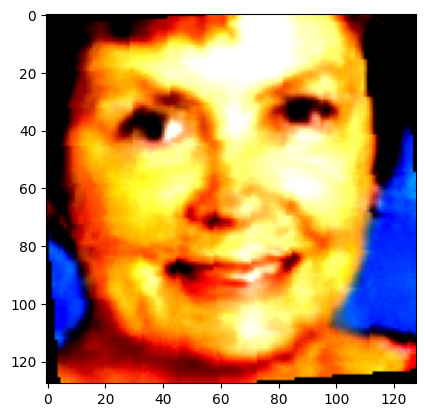

In [ ]:
images, ages, _, _= next(dataiter)
images.shape, ages.shape
plt.imshow(images[0].permute(1,2,0))

#  **Model**

🔰 Use the following template to create a custom model employing the ResNet-50 architecture

In [ ]:
class AgeEstimationModel(nn.Module):

  def __init__(self):
    super().__init__()
    self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    self.model.fc  = nn.Linear(in_features=2048, out_features=1, bias=True)


  def forward(self, x):
    output = self.model(x)
    return output


🔰 Create an object for model using the AgeEstimationModel class you've created.

In [ ]:
model = AgeEstimationModel()
model

#  **Config**

🔰 Define the optimizer, loss function, and metrics in this section, and ensure the model is sent to the appropriate device.

In [ ]:
device = 'cuda' if torch.cuda.is_available()  else 'cpu'
model = model.to(device)

In [ ]:
loss_fn = nn.L1Loss()

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9, weight_decay=1e-4)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.02
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)

In [ ]:
metric = tm.MeanAbsoluteError().to(device)

#  **Train**

🔰Write the train function.

In [ ]:
with tqdm.tqdm(range(10000)) as  loop:
  for i in loop:
    a= i

100%|██████████| 10000/10000 [00:00<00:00, 1520997.97it/s]


In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=None):
  # this method will train the model for one epoch

  #set the model to the train state
  model.train()

  epoch_loss = AverageMeter()
  metric.reset();
  with tqdm.tqdm(train_loader, unit='batch') as TL:
    for inputs, ys, _, _  in TL:

      if epoch:
        TL.set_description(f'Epoch: {epoch}')

      #to use GPU we should move data to device we defined in config section
      # if device == 'cuda' data go on GPU, otherwise go on CPU
      inputs = inputs.to(device)
      ys = ys.to(device)


      # train steps
      optimizer.zero_grad()
      y_hats = model(inputs)
      loss = loss_fn(y_hats, ys )
      loss.backward()
      optimizer.step()

      epoch_loss.update(loss.item(), len(inputs))
      metric.update(y_hats, ys)
      TL.set_postfix(loss= epoch_loss.avg, metric= metric.compute().item())

  return model, epoch_loss.avg, metric.compute().item()


In [ ]:
#train_one_epoch(model,train_dataloader, loss_fn, optimizer,metric, 1)

#  **Evaluation**

🔰Write the evaluation function.

In [ ]:
def evaluate(model, test_loader, loss_fn, metric):
  model.eval()
  eval_loss = AverageMeter()
  metric.reset()

  with torch.no_grad():
    for inputs, ys, _, _ in test_loader:

      #to use GPU we should move data to device we defined in config section
      # if device == 'cuda' data go on GPU, otherwise go on CPU
      inputs = inputs.to(device)
      ys = ys.to(device)


      y_hats = model(inputs)
      loss = loss_fn(y_hats, ys)
      eval_loss.update(loss.item())

      metric.update(y_hats, ys)
      #print(eval_loss.avg, metric.compute().item())
  return eval_loss.avg, metric.compute().item()

In [ ]:
#evaluate(model, valid_dataloader, loss_fn,metric)

#  **Training Process**

##  Finding Hyper-parameters

###  **Step 1:** Calculate the loss for an untrained model using a few batches.


In [ ]:
untrained_model_test = AgeEstimationModel().to(device)

xs, ys, _, _ = next(iter(train_dataloader))
xs = xs.to(device)
ys = ys.to(device)

with torch.no_grad():
  y_hats = untrained_model_test(xs)
  loss = loss_fn(y_hats, ys)

print(loss)

tensor(31.1358)


In [ ]:
torch.cuda.empty_cache()


temp = torch.tensor(1, device=device)
model = temp.clone()
optimizer = temp.clone()
xs = temp.clone()
ys = temp.clone()
y_hats = temp.clone()

In [ ]:
'''j =0
for  inp,outp,*_  in tqdm.notebook.tqdm_notebook(valid_dataloader ):
  j+=1
  print(j)


###  **Step 2:** Try to train and overfit the model on a small subset of the dataset.

In [ ]:
# overfit : use small subset of samples and train the model reaching loss to about 0
#---------- teacher's method --------
mini_train_size = 1000
_, tr_data = random_split(train_dataset, [len(train_dataset)-mini_train_size,mini_train_size])
mini_train_loader = DataLoader(tr_data, batch_size=20)

model = AgeEstimationModel().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)


In [ ]:
epochs = 10
for epoch in range(epochs):
  model, _, _ = train_one_epoch(model, mini_train_loader,loss_fn, optimizer, metric, epoch)

In [ ]:
for inp,outp,_,_ in fpDataloader:
  print(outp)

In [ ]:
plt.plot(range(17),trloss_lst[3:],'-r')
plt.plot(range(17),evalloss_lst[3:],'-b')

In [ ]:
epochs =20
trloss_lst=[]
evalloss_lst= []
for i in range(epochs):
  fp_model, epochloss = train_one_epoch(fp_model, fpDataloader,loss_fn, optimizer,metric, i)
  evalloss, _ = evaluate(fp_model, valid_dataloader, loss_fn,metric)
  print(f'train loss:{epochloss}')
  print(f'eval loss:{evalloss}')
  trloss_lst.append(epochloss)
  evalloss_lst.append(evalloss)

#plt.plot(range(epochs),trloss_lst,'-r')
#plt.plot(range(epochs),evalloss_lst,'-b')


###  **Step 3:** Train the model for a limited number of epochs, experimenting with various learning rates.

In [ ]:
epochs =3
lr_list= [0.1,0.01,0.001,0.0001]

for lrate in lr_list:
  print(f'LR = {lrate}')
  fp_model = AgeEstimationModel().to(device)
  optimizer = optim.SGD(fp_model.parameters(), lr=lrate, momentum=0.9, weight_decay=1e-4)

  for i in range(epochs):
    fp_model, epochloss, _ = train_one_epoch(fp_model, train_dataloader,loss_fn, optimizer,metric, i)



###  Step 4: Create a small grid using the weight decay and the best learning rate.





In [ ]:
epochs =3
lr_list= [0.005,0.003,0.001,0.0007]
weight_decay = [1e-4, 1e-5, 0]

for lrate in lr_list:
  for wd in weight_decay:
    print(f'LR = {lrate}, wd = {wd}')
    fp_model = AgeEstimationModel().to(device)
    optimizer = optim.SGD(fp_model.parameters(), lr=lrate, momentum=0.9, weight_decay=wd)

    for i in range(epochs):
      fp_model, epochloss, _ = train_one_epoch(fp_model, train_dataloader,loss_fn, optimizer,metric, i)


###  Step 5: Train model for longer epochs using the best model from step 4.





In [ ]:
model = AgeEstimationModel().to(device)


In [ ]:
lr = 0.001
wd = 1e-4
optimizer = torch.optim.SGD(model.parameters(),lr=lr, weight_decay=wd, momentum=0.9)

In [ ]:
loss_train_hist =[]
loss_valid_hist =[]
metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
  model, loss_train, metric_train = train_one_epoch(model, train_dataloader
                                                 , loss_fn
                                                 ,optimizer, metric, epoch)
  loss_valid, metric_valid = evaluate(model,  valid_dataloader, loss_fn, metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)
  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved.')

  print(f"Valid: Loss = {loss_valid: 0.4} , MAE = {metric_valid: 0.4}")
  print()

  epoch_counter +=1


##  Main Loop

🔰 Define model.

In [ ]:
model = AgeEstimationModel().to(device)

🔰 Define optimizer and Set learning rate and weight decay.

In [ ]:
lr = 0.001
wd = 1e-4
optimizer = torch.optim.SGD(model.parameters(),lr=lr, weight_decay=wd, momentum=0.9)

🔰 Write code to train the model for `num_epochs` epoches.

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
  model, loss_train, metric_train = train_one_epoch(model, train_dataloader
                                                 , loss_fn
                                                 ,optimizer, metric, epoch)
  loss_valid, metric_valid = evaluate(model,  valid_dataloader, loss_fn, metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)
  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved.')

  print(f"Valid: Loss = {loss_valid: 0.4} , MAE = {metric_valid: 0.4}")
  print()

  epoch_counter +=1

##  Plot

🔰 Plot learning curves

In [ ]:
plt.figure(figsize = (8,6))

plt.plot(range(epoch_counter), loss_train_hist, 'r-', label = 'Train' )
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label = 'Validation' )

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

#  **Test**

🔰 Test your model using data from the test set and images that are not present in the dataset.

In [ ]:
model_path = 'model.pt'
model = torch.load(model_path)
model.eval()

In [ ]:
_, train_metric = evaluate(model, train_dataloader, loss_fn, metric)
_, valid_metric = evaluate(model, valid_dataloader, loss_fn, metric)
_, test_metric = evaluate(model, test_dataloader, loss_fn, metric)

train_metric, valid_metric, test_metric

#  **Inference**

🔰 your mission is to:

*   Write an inference function.
*   load an image from outside the UTKFace dataset
*   and evaluate the model's prediction.

In [ ]:
!pip install -q face_recognition

In [ ]:
import face_recognition

In [ ]:
def inference(image_path, transform, model, face_recog= False):

  if face_recog:
    img = face_recognition.load_image_file(image_path)
    top, right, bottom, left = face_recognition.face_locations(img)[0]
    img_cropped = img[top:bottom, left:right]
    img_cropped = Image.fromarray(img_cropped)
  else:
    img_cropped = Image.open(image_path).convert('RGB')

  img_tensor = transform(img_cropped).unsqueeze(0)
  with torch.inference_mode():
    pred = model(img_tensor.to(device)).item()

  return pred, img


In [ ]:
prediction, image = inference('contenct/123.jpg', test_transform
                              , model, False)
print(f'{prediction:.2}')
image

In [ ]:
img_folder_path = 'content/Data'
test_df = pd.read_csv('content/test_set.csv')

rand_idx = random.randint(0, test_date.shape[0])
image_address = os.path.join(img_folder_path ,test_df.iloc[rand_idx])
pred, img  = inference(image_address, test_transform, model, False)

print(f'Real : {test_df[rand_idx].split('_')[0]}, Prediction : {pred: .2}')
img

#  **Experiments**

In [ ]:
# !cp /content/drive/mydrive/...  /content

In [ ]:
model = torch.load('/content/model.pt')
model.eval()

##  Train and evaluate the model using various datasets.

##  Train the model using one dataset and then test it on a different one.

## Analyze the loss value with respect to age, gender and race.

In [ ]:
all_outputs , all_targets = [],[]


In [ ]:
for inputs, targets in test_dataloader:
  inputs = inputs.to(device)
  targets = targets.to(device)

  with torch.inference_mode():
    output = model(inputs)

all_outputs.append(output)
all_targets.append(targets)


In [ ]:
all_outputs = torch.vstack(all_outputs).squeeze()
all_targets = torch.vstack(all_targets).squeeze()

In [ ]:
maes = F.l1_loss(all_outputs,all_targets, reduction='none')

In [ ]:
df_test = pd.read_csv('/content/test_set.csv')
dt_test['preds'] = all_outputs.cpu()
dt_test['maes'] = maes.cpu()
df_test.to_csv('/content/test_outputs.csv')

In [ ]:
# groupby groups the data based on unique values in the given field.
df_test.groupby('age')['maes'].describe()

In [ ]:
plt.figure(figsize=(16,6))
plt.bar(df_test.groupby('age')['maes'].describe().index,
        df_test.groupby('age')['maes'].describe()['mean'])

In [ ]:
plt.figure(figsize=(16,6))
plt.hist(df_test.age, bins=len(df_test.age.unique()))

In [ ]:
#اگر بخواهیم از تحلیل های بالا یک جمع بندی بکنیم اینه که وقتی تعداد نمونه داده کم باشه خطا زیاد شده.
#

In [ ]:
df_test.groupby('gender')['maes'].describe()

In [ ]:
# اینجا مثلا چون خطا در خانم ها کم است علت این میتونه باشه که در پلات ویولون در بخش
# EDA
# میبینیم که تعداد سمپلها برای خانم ها در سنین بالا کم است و بیشتر سمپلها مال سنین میانی است
#و چون مدل ما هم برای سنین میانی خوب کار میکند پس برای خانم ها خطای کمی تولید شده.

In [ ]:
df_test.groupby('ethnicity')['maes'].describe()

In [ ]:
ranges = np.arange(df_test.age.min()-1, df_test.age.max()+1, 5)
df_test['age_periods'] = pd.cut(df_test.age, ranges)
df_test.head()

In [ ]:
plt.figure(figsize=(16,6))
plt.bar(ranges[:,-1],
        df_test.groupby('age_periods')['maes'].describe()['mean'])

In [ ]:
df_test.groupby('age_periods')['maes'].describe()

##  Analyze the model's sensitivity.

In [ ]:
test_image_path = '/content/image2.png'
img2 = Image.open(test_image_path).convert('RGB')

image_tensor = test_transform(img2).unsqueeze(0)

with torch.inference_mode():
  predicted_age = model(image_tensor.to(device)).item()

print(f'predicted age {predicted_age,.2}')
img2